In [1]:
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt
from hamp_pred.src.output_analysis.visual import reg_plot

In [2]:
data = pd.read_pickle('../data/input/full_alpha_data.p')
val_ids = set(data[data['class'] == 'val'].index)
val_data = data.loc[val_ids]

test_data = pd.read_pickle('../data/input/full_pdb_hamp.p')
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
mutants_ids = ['5jeq.pdb',
            '5jef.pdb',
            '3zrv.pdb',
            '2lfs.pdb',
            '3zrw.pdb',
            '3zcc.pdb',
            '2l7i.pdb', '2y20.pdb', '2y21.pdb', '2y0q.pdb',
                    
            '3lnr.pdb', 
                    '4i44.pdb', '4i3m.pdb'

           
           ]
test_wild, test_mutants = test_data.drop(mutants_ids), test_data.loc[mutants_ids]

/tmp/ipykernel_31761/1494028047.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val_data = data.loc[val_ids]


# Aligned helix rotation

In [3]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)
model_conf = model_config = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 1,
    'reshape_out': False,
    'epochs': 100
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
mod = Predictor('hamp_rot', config=conf)

## Validation

In [4]:
val_results = mod.predict(val_data, is_test=True)
print(f"RMSE_SEQ: {val_results['mse_seq']**0.5}\nRMSE_POS: {val_results['mse_pos']**0.5}")

2022-10-05 13:16:21.737721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 13:16:23.111538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7390 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-10-05 13:16:23.114724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7388 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1
2022-10-05 13:16:26.810111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-10-05 13:16:27.184119: I

1/1 [==============================] - 3s 3s/step
RMSE_SEQ: 4.572273568381617
RMSE_POS: 5.260703796691048


<AxesSubplot:title={'center':'Predictions for data set'}, xlabel='Predicted', ylabel='True'>

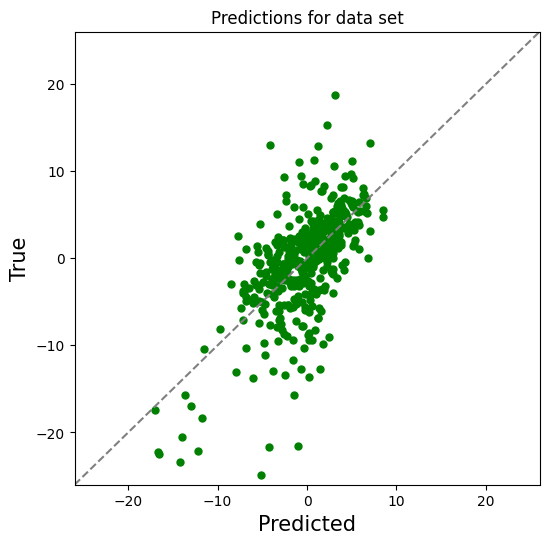

In [5]:
reg_plot(val_results['true_mean_rot'], val_results['pred_mean_rot'])

## Test Wild

In [6]:
test_wild_results = mod.predict(test_wild, is_test=True)
print(f"RMSE_SEQ: {test_wild_results['mse_seq']**0.5}\nRMSE_POS: {test_wild_results['mse_pos']**0.5}")

1/1 [==============================] - 2s 2s/step
RMSE_SEQ: 5.068880745146601
RMSE_POS: 7.532340451238352


<AxesSubplot:title={'center':'Predictions for WT HAMPs (no mutants)'}, xlabel='Predicted', ylabel='True'>

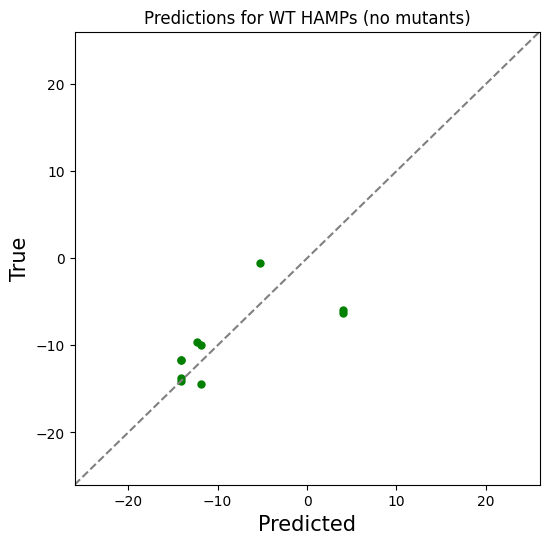

In [7]:
reg_plot(test_wild_results['true_mean_rot'], test_wild_results['pred_mean_rot'], title='Predictions for WT HAMPs (no mutants)')

## Test Mutants

In [8]:
test_mutants_results = mod.predict(test_mutants, is_test=True)
print(f"RMSE_SEQ: {test_mutants_results['mse_seq']**0.5}\nRMSE_POS: {test_mutants_results['mse_pos']**0.5}")

1/1 [==============================] - 2s 2s/step
RMSE_SEQ: 5.212575024998622
RMSE_POS: 5.002525367354054


<AxesSubplot:title={'center':'Predictions for Mutants'}, xlabel='Predicted', ylabel='True'>

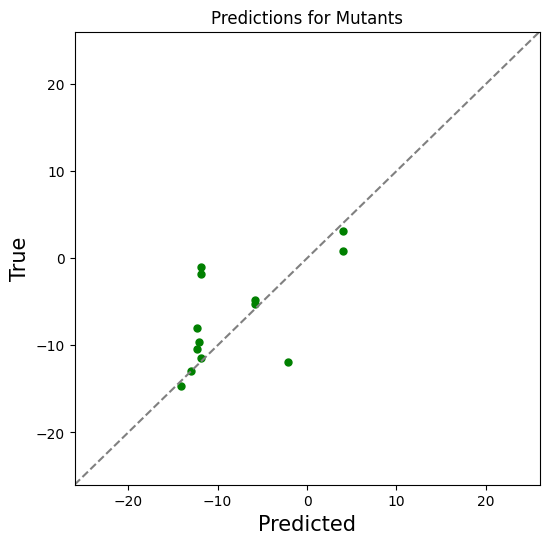

In [9]:
reg_plot(test_mutants_results['true_mean_rot'], test_mutants_results['pred_mean_rot'], title='Predictions for Mutants')

# Full length helix rotation

In [10]:
pred = Predictor('hamp_crick_single_sequence')

## Validation

In [11]:
val_results_full = pred.predict(val_data, is_test=True)
print(f"RMSE_SEQ: {val_results_full['mse_seq']**0.5}\nRMSE_POS: {val_results_full['mse_pos']**0.5}")

1/1 [==============================] - 2s 2s/step


/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


RMSE_SEQ: 6.041207943431768
RMSE_POS: 24.501734549604848


<AxesSubplot:title={'center':'Predictions for data set'}, xlabel='Predicted', ylabel='True'>

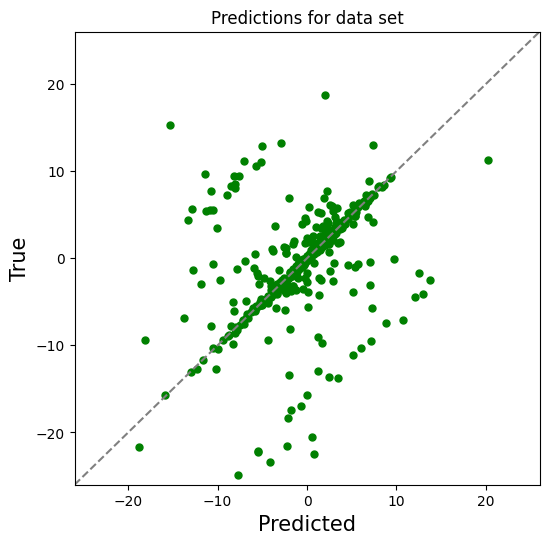

In [12]:
reg_plot(val_results_full['true_mean_rot'], val_results_full['pred_mean_rot'])

## Test Wild

In [13]:
test_wild_results_full = pred.predict(test_wild, is_test=True)
print(f"RMSE_SEQ: {test_wild_results_full['mse_seq']**0.5}\nRMSE_POS: {test_wild_results_full['mse_pos']**0.5}")

1/1 [==============================] - 2s 2s/step
RMSE_SEQ: 9.575288332769036
RMSE_POS: 69.94615312732779


/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


<AxesSubplot:title={'center':'Prediction for WT HAMPs (no mutants)'}, xlabel='Predicted', ylabel='PDB Structure'>

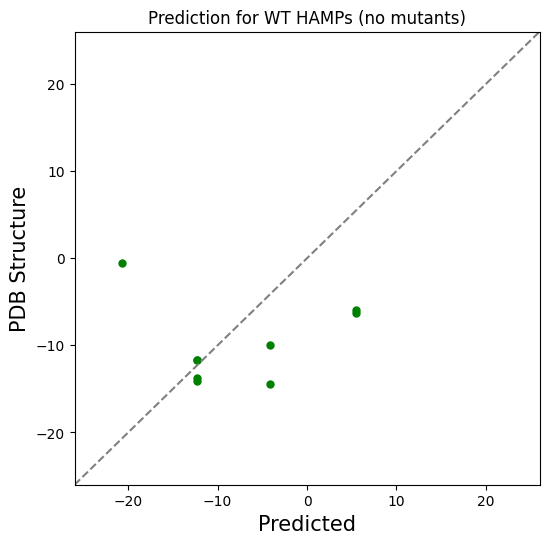

In [20]:
reg_plot(test_wild_results_full['true_mean_rot'], test_wild_results_full['pred_mean_rot'], title='Prediction for WT HAMPs (no mutants)', ylabel='PDB Structure')

## Test Mutants

In [17]:
test_mutants_results_full = pred.predict(test_mutants, is_test=True)
print(f"RMSE_SEQ: {test_mutants_results_full['mse_seq']**0.5}\nRMSE_POS: {test_mutants_results_full['mse_pos']**0.5}")

1/1 [==============================] - 2s 2s/step
RMSE_SEQ: 5.189079722549444
RMSE_POS: 57.03441502756333


/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


<AxesSubplot:title={'center':'Prediction for HAMPs mutants'}, xlabel='Predicted', ylabel='PDB Structure'>

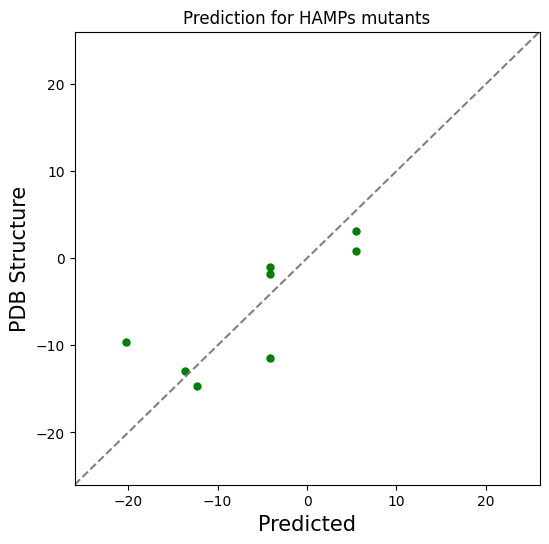

In [21]:
reg_plot(test_mutants_results_full['true_mean_rot'], test_mutants_results_full['pred_mean_rot'], title='Prediction for HAMPs mutants', ylabel="PDB Structure")